In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_json("Magazine_Subscriptions.jsonl", lines=True)

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
def preprocessing_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # # Remove URLs
    text = re.sub(r'\<a href','', text)  # Remove HTML tags
    text = re.sub(r'&amp;', '', text) # Remove HTML entities
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]','', text) # Remove punctuation and special characters
    text = re.sub(r'<br />','', text)  # Remove specific HTML line breaks
    text = re.sub(r'\'','', text) # Remove apostrophes
    text = re.sub(r'\d+','', text) # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'[^\w\s,]', '', text) # Remove emojis
    
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizr = WordNetLemmatizer()
    words = [lemmatizr.lemmatize(word) for word in words]
    processed_text = ' '.join(words)
    
    return processed_text

In [5]:
df['processed_text'] = df['text'].apply(preprocessing_text)

In [6]:
def apply_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [7]:
df['entities'] = df['processed_text'].apply(apply_ner)

In [8]:
def filter_entities(entities):
    relevant_labels = {"PRODUCT", "ORG", "GPE", "DATE"}
    return [ent for ent in entities if ent[1] in relevant_labels]

In [9]:
df['filtered_entities'] = df['entities'].apply(filter_entities)

In [10]:
all_entities = [entity for entities in df['entities'] for entity in entities]
entities_df = pd.DataFrame(all_entities, columns=['Entity', 'Label'])

In [11]:
entity_counts = entities_df['Label'].value_counts()

In [17]:
entities_df

,Entity,Label
0,year,DATE
1,joy kosher,PERSON
2,kosher lifestyle,PERSON
3,dozen,CARDINAL
4,kosher,PERSON
...,...,...
64667,three,CARDINAL
64668,justine,PERSON
64669,two day ago,DATE
64670,october,DATE


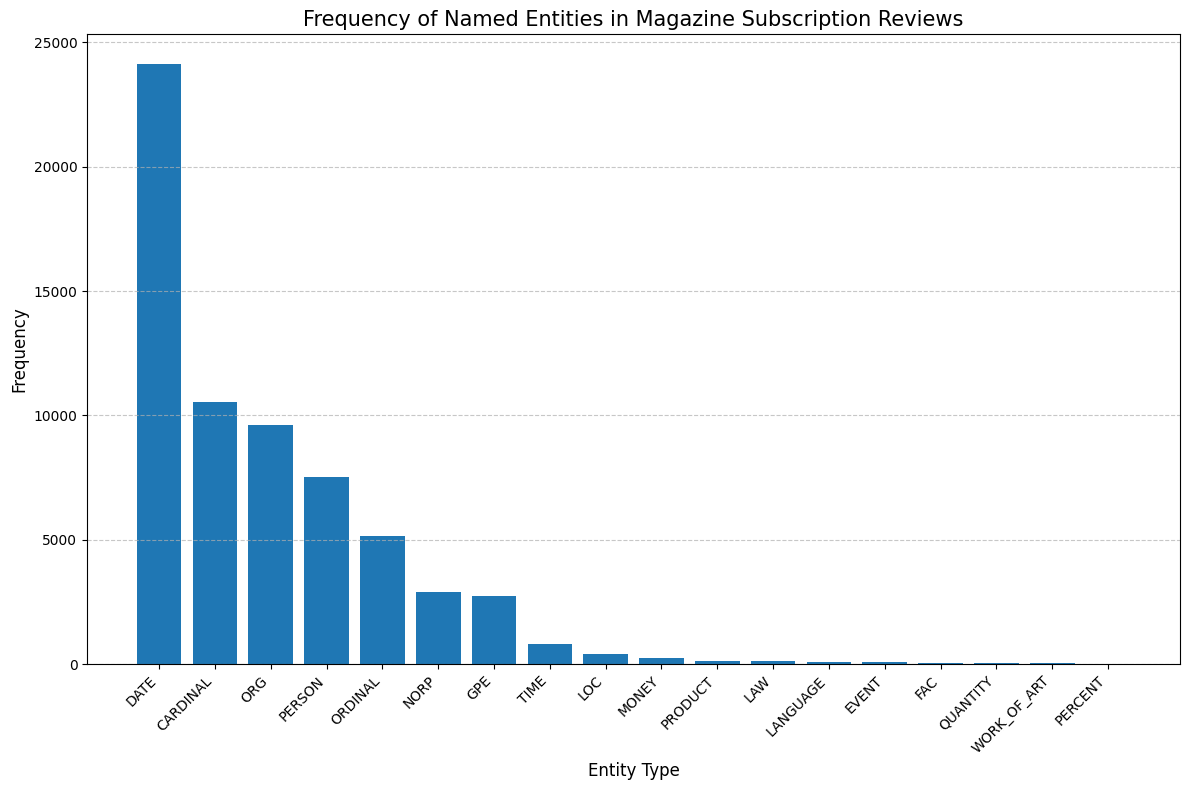

In [12]:
plt.figure(figsize=(12, 8))  # Increase figure size
plt.bar(entity_counts.index, entity_counts.values)
plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of Named Entities in Magazine Subscription Reviews', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

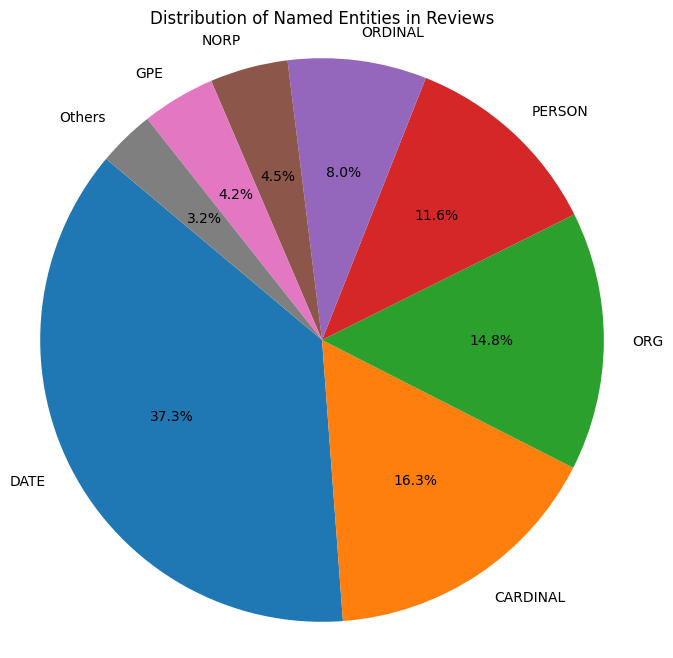

In [13]:

top_n = 7
top_entities = entity_counts.head(top_n)
others_count = entity_counts.iloc[top_n:].sum()
top_entities['Others'] = others_count

# Plotting the pie chart with top 5 and "Others"
plt.figure(figsize=(8, 8))
plt.pie(top_entities.values, labels=top_entities.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Distribution of Named Entities in Reviews')
plt.show()

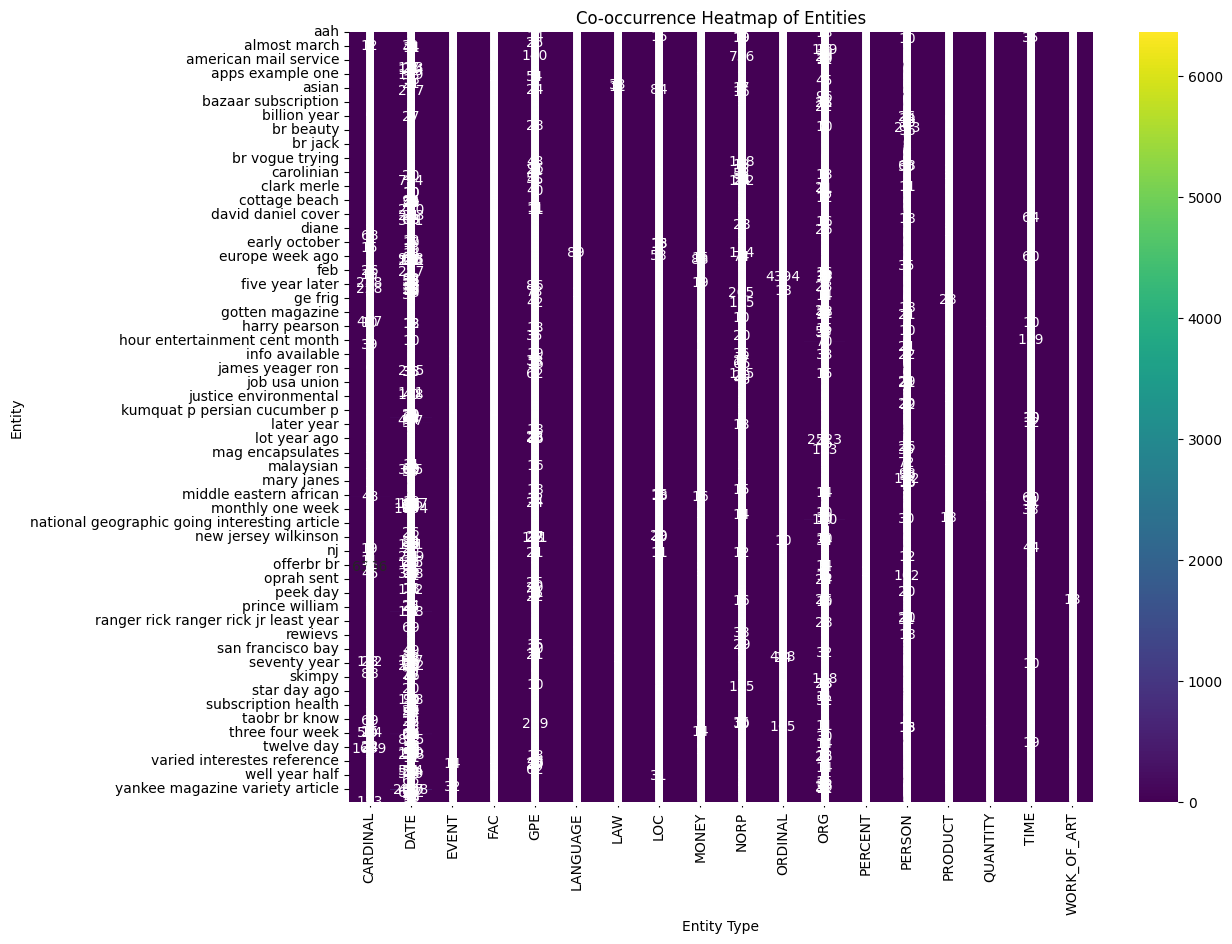

In [14]:
co_occurrence_matrix = pd.crosstab(entities_df['Entity'], entities_df['Label'])

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap='viridis', annot=True, fmt='d')
plt.title('Co-occurrence Heatmap of Entities')
plt.xlabel('Entity Type')
plt.ylabel('Entity')
plt.show()

In [15]:
# Aggregate entity counts for products and brands
product_counts = entities_df[entities_df['Label'] == 'PRODUCT']['Entity'].value_counts()
brand_counts = entities_df[entities_df['Label'] == 'ORG']['Entity'].value_counts()

In [16]:
print("Top 10 Products:")
print(product_counts.head(10))

print("\nTop 10 Brands:")
print(brand_counts.head(10))

Top 10 Products:
Entity
geo                 28
nat geo             18
bmw                  9
xbox                 7
cole                 5
google newsstand     3
bmw audi             3
kairos bud           2
geo mag              2
discovery            2
Name: count, dtype: int64

Top 10 Brands:
Entity
love                   2523
amazon                  159
mag                     153
smithsonian             138
national geographic     100
awesome                  96
house                    70
hgtv                     58
subscription             52
loved                    46
Name: count, dtype: int64
